In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
#%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from ganime.data.base import load_dataset
from ganime.utils.statistics import dataset_statistics
from ganime.model.vqgan_clean.vqgan import VQGAN
from ganime.visualization.videos import display_images, display_videos
import tensorflow as tf
from datetime import datetime
from tqdm import tqdm
#tf.get_logger().setLevel('ERROR')

In [4]:
for device in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(device, True)

In [5]:
num_workers = len(tf.config.list_physical_devices("GPU"))
batch_size = 128

In [6]:
logdir = "../../../logs/ganime/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Define the basic TensorBoard callback.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [7]:
#train_ds, test_ds, input_shape = load_dataset("kny_images", "../../../data", batch_size=128)

In [8]:
from tensorflow.keras.utils import Sequence
import numpy as np
import skvideo.io
import os
from skimage.transform import resize
import math

class KNYImages(Sequence):

    def __init__(self, dataset_path: str, batch_size: int, split="train"):
        self.data = np.load(os.path.join(dataset_path, "kny", "kny_images_64x128.npy"))
        if split == "train":
            self.data = self.data[:-5000]
        else:
            self.data = self.data[-5000:]
            
        self.data = self.data / 255
        self.batch_size = batch_size
        self.indices = np.arange(self.data.shape[0])
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_x = self.data[inds]
        batch_y = batch_x

        return batch_x, batch_y
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

In [9]:
train_ds = KNYImages("../../../data", batch_size=batch_size, split="train")

In [10]:
test_ds = KNYImages("../../../data", batch_size=batch_size, split="test")

In [11]:

import io
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

class TensorBoardImage(tf.keras.callbacks.Callback):

    def __init__(self, logdir, train, validation=None):
        super(TensorBoardImage, self).__init__()
        self.logdir = logdir
        self.train = train
        self.validation = validation
        self.file_writer = tf.summary.create_file_writer(logdir)

    def on_epoch_end(self, epoch, logs):
        train_imgs = self.train[0][0]
        val_imgs = self.validation[0][0][:10]

        train_pred = self.model.predict(train_imgs)
        validation_pred = self.model.predict(val_imgs)

        with self.file_writer.as_default():
            tf.summary.image("Training data", plot_to_image(display_images(train_pred)), step=epoch)
            tf.summary.image("Validation data", plot_to_image(display_images(validation_pred)), step=epoch)

tensorboard_image_callback = TensorBoardImage(logdir=logdir, train=train_ds, validation=test_ds)

2022-05-21 07:25:22.276827: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-21 07:25:25.145149: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14252 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-05-21 07:25:25.146300: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14252 MB memory:  -> device: 1, name: NVIDIA RTX A4000, pci bus id: 0000:25:00.0, compute capability: 8.6
2022-05-21 07:25:25.147212: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 w

In [12]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


In [13]:
train_mean, train_var, train_std = dataset_statistics(train_ds)

  0%|          | 0/227 [00:00<?, ?it/s]

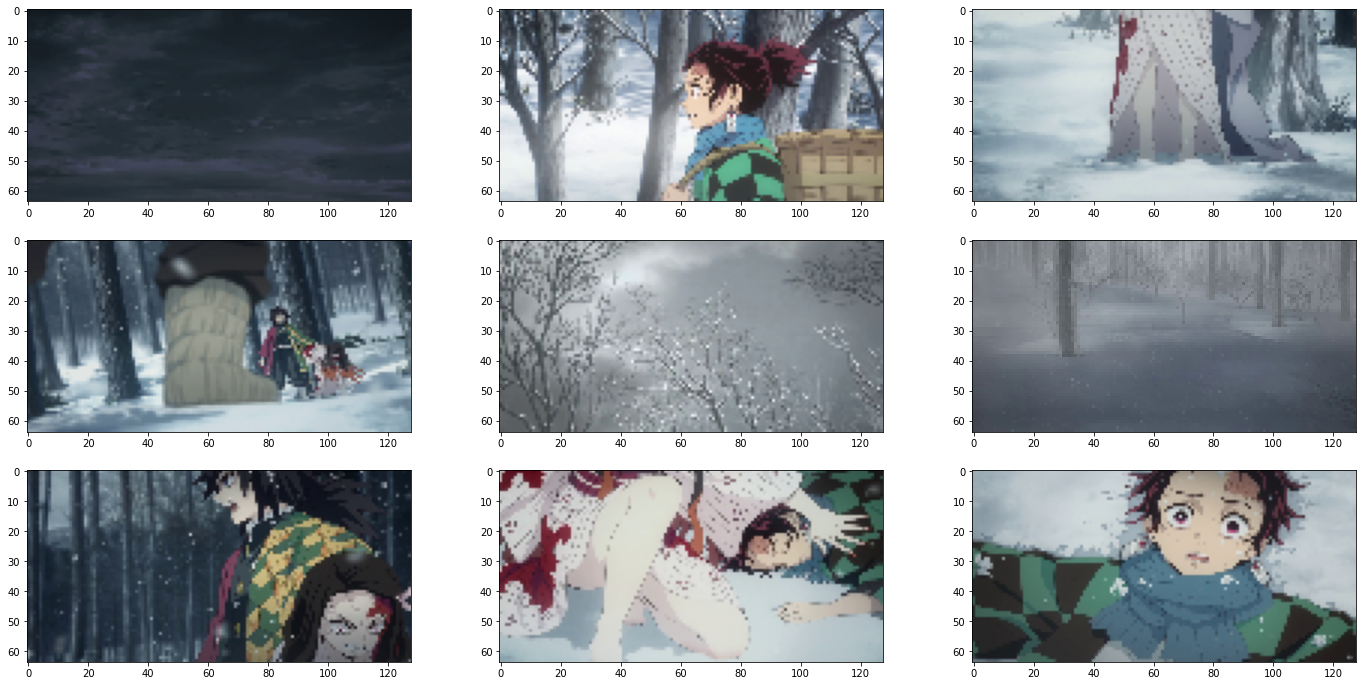

In [14]:
display_images(train_ds[100][0])
plt.show()

In [15]:
with strategy.scope():
    vqgan = VQGAN(num_embeddings=128, embedding_dim=128, train_variance=train_var, disc_iter_start=len(train_ds) * 0)

Working with z of shape (1, 128, 16, 16) = 32768 dimensions.


2022-05-21 07:25:33.090932: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


VQLPIPSWithDiscriminator running with hinge loss.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/repl

2022-05-21 07:25:34.417519: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [16]:
with strategy.scope():
    vqgan.compile(gen_optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), disc_optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5))
history = vqgan.fit(train_ds, epochs=2, steps_per_epoch=5)

2022-05-21 07:25:39.229868: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-05-21 07:25:42.564600: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-05-21 07:25:45.859960: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-05-21 07:25:49.157457: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-05-21 07:25:52.416244: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-05-21 07:25:55.669767: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-05-21 07:25:58.956195: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-05-21 07:26:01.919331: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a n

Epoch 1/2
INFO:tensorflow:batch_all_reduce: 201 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 13 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 201 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 13 all-reduces with algorithm = nccl, num_packs = 1
5/5 [==============================] - 363s 12s/step - loss: 13.8400 - reconstruction_loss: 13.0874 - vqvae_loss: 0.7629 - disc_loss: 0.9663
Epoch 2/2
5/5 [==============================] - 2s 334ms/step - loss: 15.2748 - reconstruction_loss: 12.6657 - vqvae_loss: 1.4151 - disc_loss: 0.6907


In [17]:
#history = vqgan.fit(train_ds, epochs=30, steps_per_epoch=5, callbacks=[tensorboard_callback, tensorboard_image_callback])

In [ ]:
vqgan.save("test")

INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f505c0f3c40>, 0, 0.0), {}).
INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f500415d160>, 0, 0.0), {}).
INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4f18763520>, 0, 0.0), {}).
INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4e8c5aa2b0>, 0, 0.0), {}).
INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4e1437d5b0>, 0, 0.0), {}).
INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d8c1cdbe0>, 0, 0.0), {}).
INFO:tensorflow:Unsupported signat

2022-05-21 07:32:15.759175: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f505c0f3c40>, 0, 0.0), {}).
INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f500415d160>, 0, 0.0), {}).
INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4f18763520>, 0, 0.0), {}).
INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4e8c5aa2b0>, 0, 0.0), {}).
INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4e1437d5b0>, 0, 0.0), {}).
INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4d8c1cdbe0>, 0, 0.0), {}).
INFO:tensorflow:Unsupported signat

In [ ]:
vqgan_2 = tf.keras.models.load("test")

In [ ]:
x = train_ds[100][0]
generated = vqgan_2(x[:10])

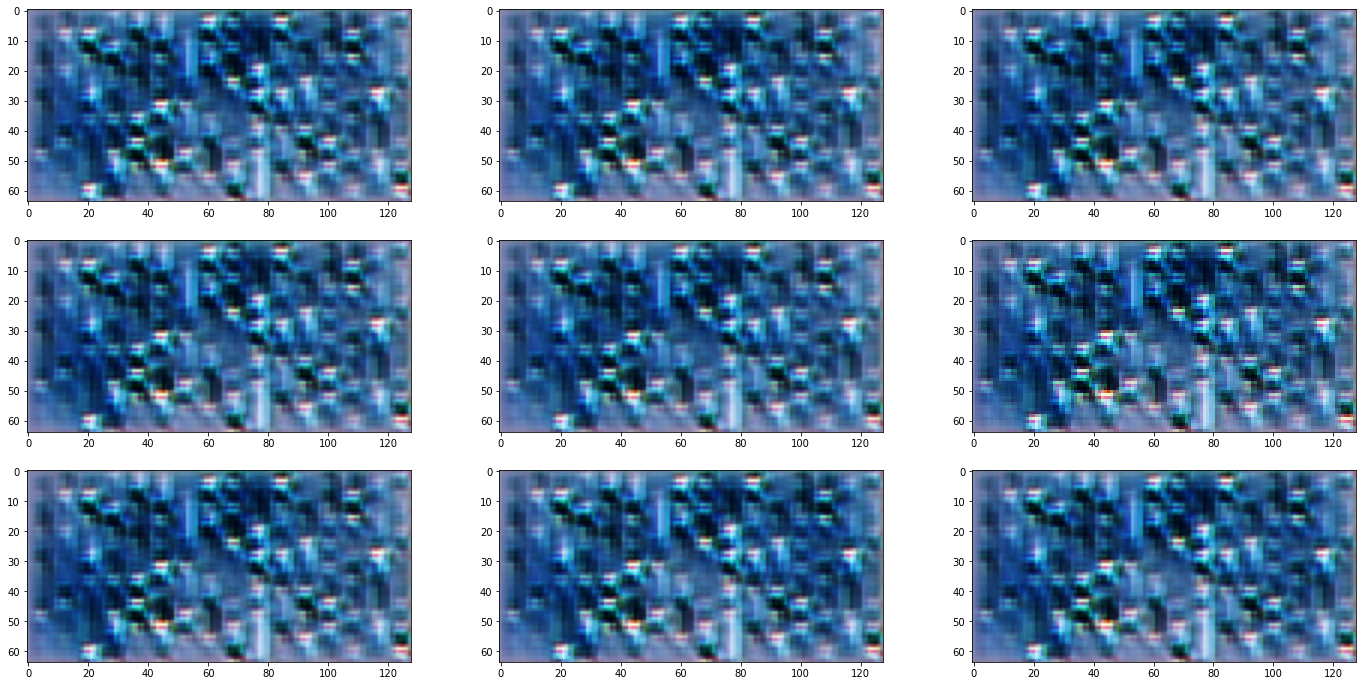

In [31]:
display_images(generated)
plt.show()

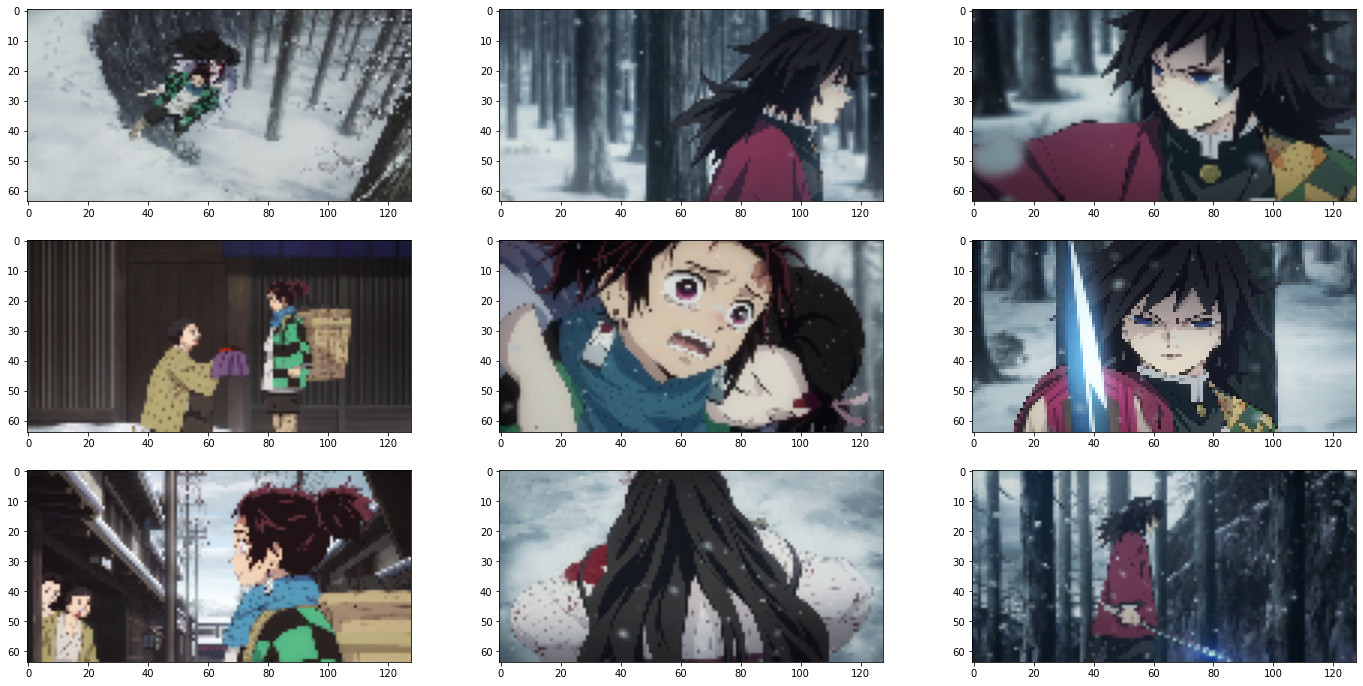

In [23]:
display_images(x)
plt.show()

In [52]:
x2 = train_ds[30][0]
generated2 = vqgan(x2[:10])

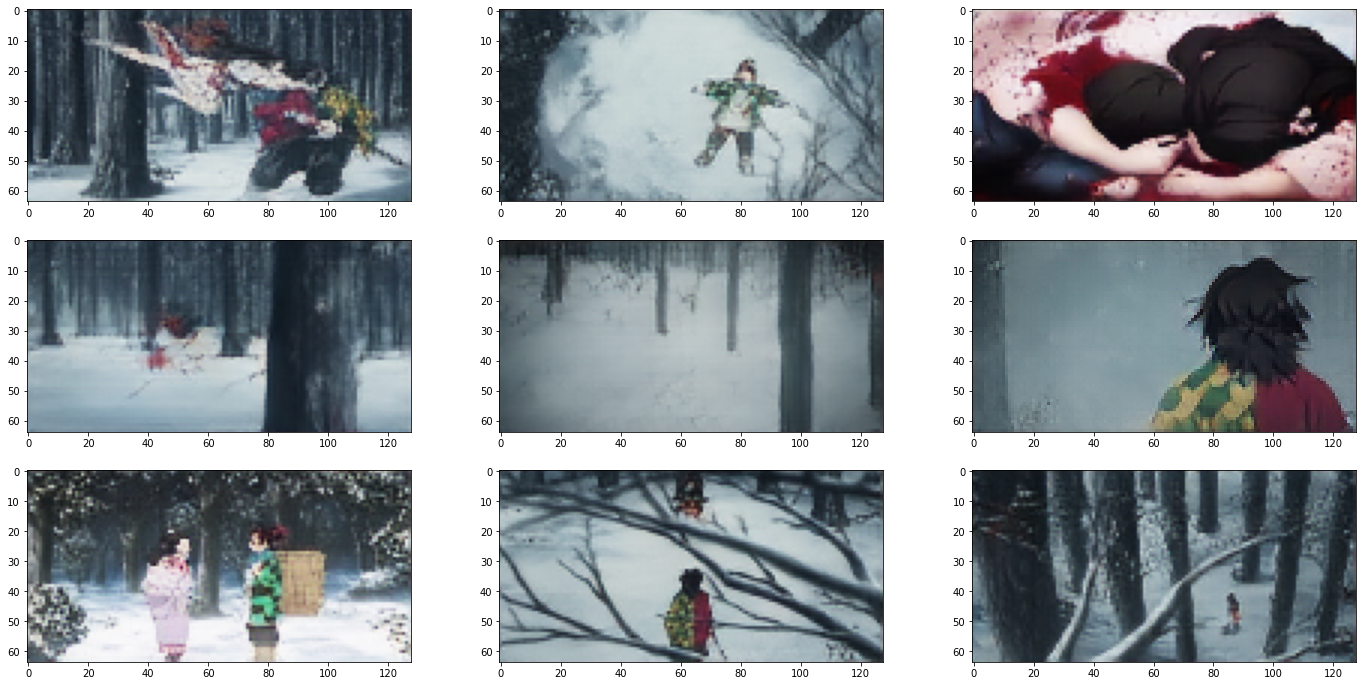

In [53]:
display_images(generated2)
plt.show()

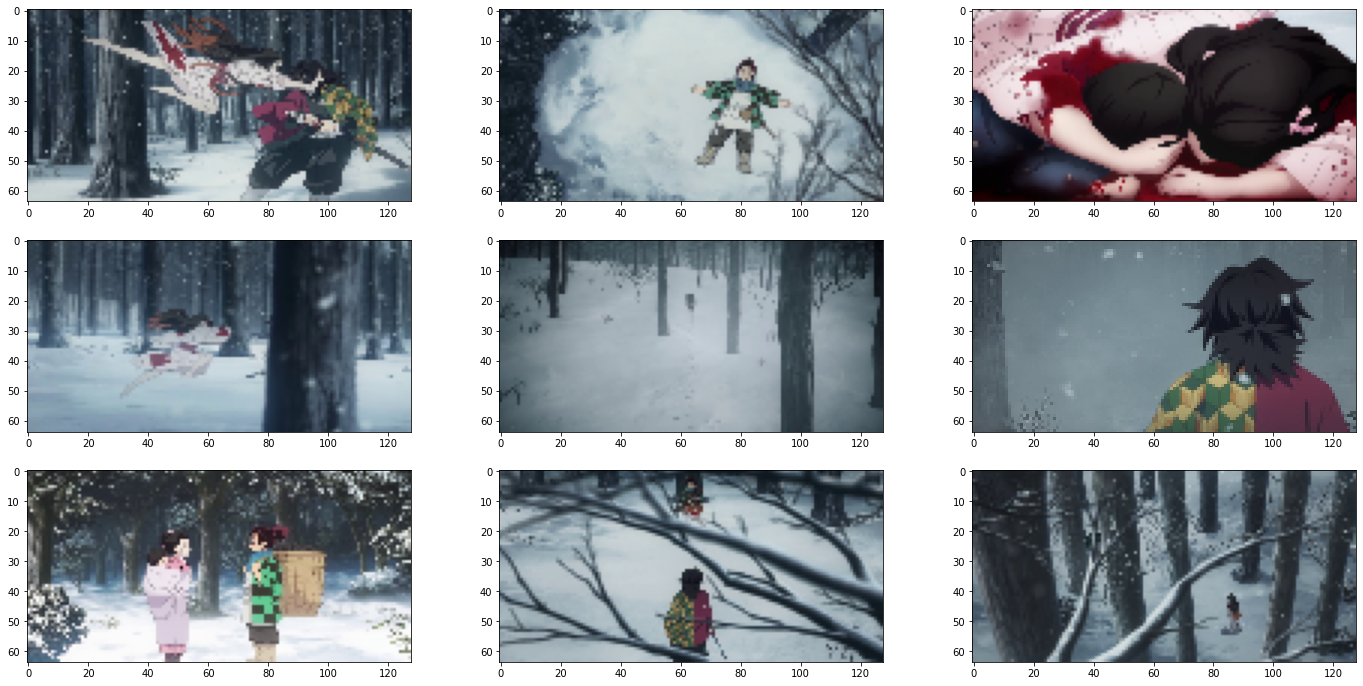

In [54]:
display_images(x2)
plt.show()

In [35]:
vqgan.save("../../../models/kny_discriminator_64x128")

INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee23129d100>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee23129d100>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee193f75e50>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee193f75e50>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee18d734070>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee18d734070>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee072ef0250>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee072ef0250>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee070df1370>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee070df1370>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edf025ad550>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edf025ad550>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edebbd66730>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edebbd66730>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ef425c6bbb0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ef425c6bbb0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8d8a640>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8d8a640>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8c17130>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8c17130>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb89d2940>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb89d2940>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb886ba60>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb886ba60>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9f1d2e0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9f1d2e0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9d09a90>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9d09a90>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9b7c400>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9b7c400>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea99699d0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea99699d0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee23129d100>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee23129d100>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee193f75e50>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee193f75e50>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee18d734070>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee18d734070>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee072ef0250>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee072ef0250>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee070df1370>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee070df1370>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edf025ad550>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edf025ad550>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edebbd66730>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edebbd66730>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ef425c6bbb0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ef425c6bbb0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8d8a640>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8d8a640>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8c17130>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8c17130>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb89d2940>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb89d2940>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb886ba60>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb886ba60>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9f1d2e0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9f1d2e0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9d09a90>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9d09a90>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9b7c400>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9b7c400>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea99699d0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea99699d0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee23129d100>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee23129d100>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee193f75e50>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee193f75e50>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee18d734070>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee18d734070>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee072ef0250>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee072ef0250>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee070df1370>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ee070df1370>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edf025ad550>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edf025ad550>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edebbd66730>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edebbd66730>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ef425c6bbb0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ef425c6bbb0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8d8a640>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8d8a640>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8c17130>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb8c17130>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb89d2940>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb89d2940>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb886ba60>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edeb886ba60>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9f1d2e0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9f1d2e0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9d09a90>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9d09a90>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9b7c400>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea9b7c400>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea99699d0>, 17025, 0.0), {}).


INFO:tensorflow:Unsupported signature for serialization: ((1.0, <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7edea99699d0>, 17025, 0.0), {}).


INFO:tensorflow:Assets written to: ../../../models/kny_discriminator_64x128/assets


INFO:tensorflow:Assets written to: ../../../models/kny_discriminator_64x128/assets
